# Overfitting and Regularisation

In [71]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

pd.options.mode.chained_assignment = None  # default='warn'

## Bias vs. Variance

see here [Компроміс зсуву та дисперсії](https://uk.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BC%D0%BF%D1%80%D0%BE%D0%BC%D1%96%D1%81_%D0%B7%D1%81%D1%83%D0%B2%D1%83_%D1%82%D0%B0_%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D1%96%D1%97)

[Understanding the bias-variance trade-off !](https://roysubhradip.hashnode.dev/understanding-the-bias-variance-trade-off)

<p align="center">
  <img src="./data/model_complexity.webp" alt="Bias-Variance Tradeoff" width="500"/>
</p>


## Overfitting

see here [Underfitting vs. Overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)

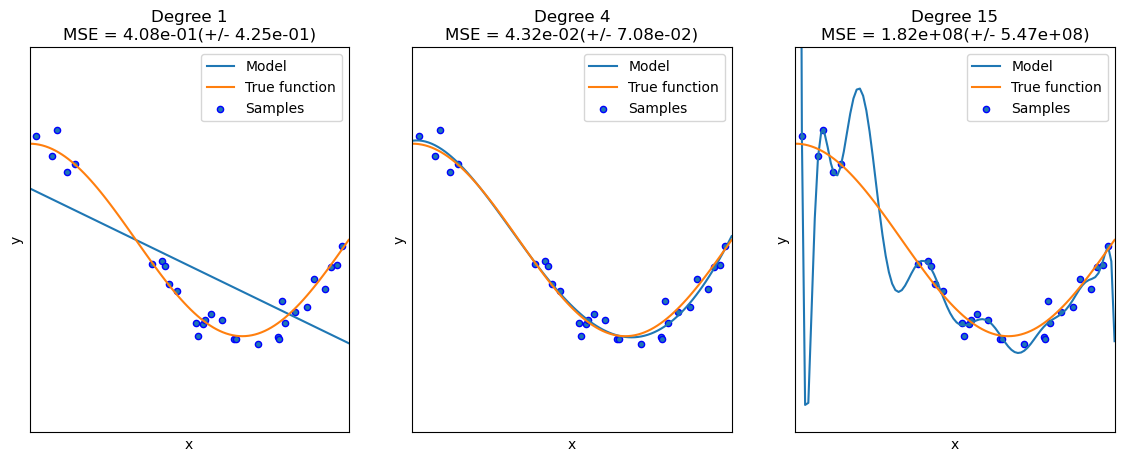

In [72]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

## Train-test spli

we will use the Kaggle Food Demand Forecasting data to demonstrate these major steps.
- Data https://kaggle.com/datasets/kannanaikkal/food-demand-forecasting/

In [73]:
# Import data from kaggle competition
PATH = "./data/food_demand"
df = pd.read_csv(os.path.join(PATH, "train.csv"), index_col=0)
# test_data = pd.read_csv(os.path.join(PATH, "test.csv"), index_col=0)

meal_info_df = pd.read_csv(os.path.join(PATH, "meal_info.csv"), index_col=0)
meal_info_df = meal_info_df.reset_index(
    drop=False  # старий індекс не буде видалено, а буде перетворений у звичайний стовпець DataFrame.
)

meal_info_df[["category", "meal_id"]].groupby(["category"]).count()
df = df.merge(meal_info_df, on="meal_id", how="left")

df.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai
2,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai
3,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian
4,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian


In [74]:
df.tail()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
456543,145,61,1543,484.09,484.09,0,0,68,Desert,Indian
456544,145,61,2304,482.09,482.09,0,0,42,Desert,Indian
456545,145,61,2664,237.68,321.07,0,0,501,Salad,Italian
456546,145,61,2569,243.50,313.34,0,0,729,Salad,Italian
456547,145,61,2490,292.03,290.03,0,0,162,Salad,Italian


In [75]:
df.cuisine.unique()

array(['Thai', 'Indian', 'Italian', 'Continental'], dtype=object)

In [76]:
# Вибираємо замовлення з магазину з ID 55, які стосуються тайської кухні
df_slice = df[(df["center_id"] == 55) & (df["cuisine"] == "Thai")]
df_slice = df_slice[["checkout_price", "num_orders"]]

# sorted by checkout_price
df_slice = df_slice.sort_values(by="checkout_price", ascending=False, axis=0)
df_slice.reset_index(
    drop=True,  #  Скидаємо старий індекс
    inplace=True,  # і створюємо новий послідовний індекс (0, 1, 2, ...), не зберігаючи старий як окрему колонку
)
df_slice

,checkout_price,num_orders
0,321.13,26
1,321.13,41
2,321.13,26
3,321.13,15
4,321.13,28
...,...,...
1274,80.54,55
1275,80.54,53
1276,80.54,54
1277,79.54,55


In [77]:
# train-test-split with sklearn
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_slice, shuffle=False, test_size=0.25)
train_data.tail()

,checkout_price,num_orders
954,146.5,68
955,146.5,285
956,146.5,204
957,146.5,82
958,146.5,94


In [78]:
test_data.head()

,checkout_price,num_orders
959,146.5,94
960,146.5,284
961,146.5,121
962,146.5,163
963,146.5,203


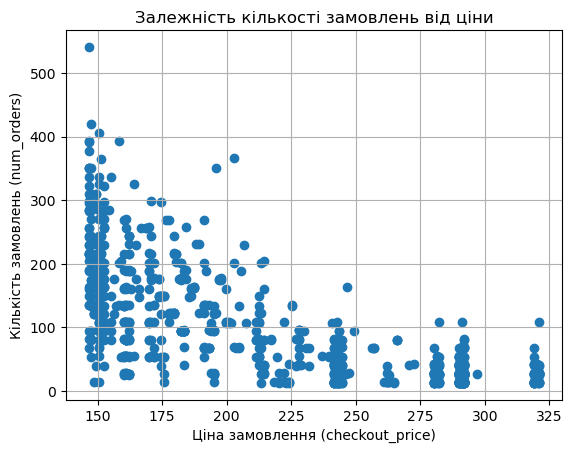

In [79]:
plt.scatter(train_data["checkout_price"], train_data["num_orders"])
plt.xlabel("Ціна замовлення (checkout_price)")
plt.ylabel("Кількість замовлень (num_orders)")
plt.title("Залежність кількості замовлень від ціни")
plt.grid(True)
plt.show()

In [80]:
# Чому не треба дивитись на графік із test_data?
# Якщо ти робиш графік або аналіз на тестових даних перед тим, як побудував модель, то це нормально — це як "контрольна перевірка".

# Але якщо ти дивишся на тестові дані, щоб налаштовувати модель або робиш аналіз, який потім впливає на тренування — ти "дивишся у майбутнє", і це є витік даних.

# Тобто, тестові дані мають бути "чистими", не відомими моделі до кінця тренування.


# plt.scatter(test_data["checkout_price"], test_data["num_orders"])
# plt.xlabel("Ціна замовлення (checkout_price)")
# plt.ylabel("Кількість замовлень (num_orders)")
# plt.title("Залежність кількості замовлень від ціни")
# plt.grid(True)
# plt.show()

<h3>Коротка інструкція, щоб уникнути Data Leakage</h3>
<ol>
  <li><strong>Чітко розділяй дані на тренувальні (train) і тестові (test)</strong> одразу, до будь-яких операцій з даними.</li>
  <li><strong>Використовуй тестові дані лише для фінальної оцінки моделі</strong>, після того, як модель повністю навчена і налаштована.</li>
  <li><strong>Не дивись, не аналізуй і не використовуй інформацію з тестових даних під час навчання або підбору параметрів моделі.</strong></li>
  <li><strong>Якщо робиш трансформації даних (нормалізація, масштабування, відбір ознак),</strong> навчати їх тільки на тренувальних даних і застосовувати до тестових.</li>
  <li><strong>Не використовуйте тестові дані для візуалізації під час підготовки моделі</strong> (щоб уникнути підсвідомого налаштування моделі під них).</li>
</ol>
<p>Це допоможе отримати реалістичну оцінку якості моделі і запобігти завищеним результатам.</p>


In [81]:
from sklearn.linear_model import LinearRegression

x = train_data["checkout_price"].to_numpy().reshape(-1, 1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x, y)

In [82]:
train_data["predictions"] = model.predict(x)
x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
test_data["predictions"] = model.predict(x_test)

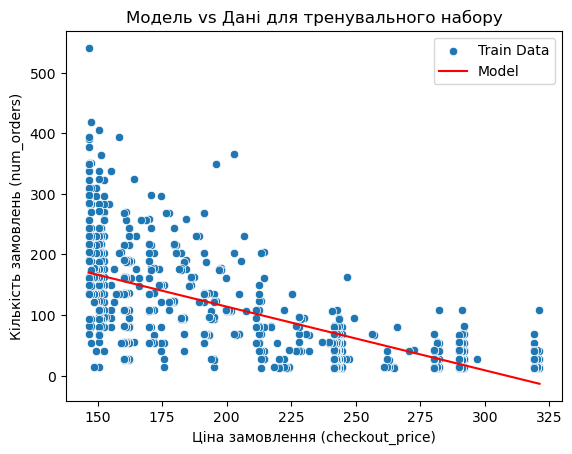

In [83]:
# Train
sns.scatterplot(x="checkout_price", y="num_orders", data=train_data, label="Train Data")
sns.lineplot(
    x="checkout_price", y="predictions", data=train_data, color="red", label="Model"
)
# Додаткові елементи
plt.xlabel("Ціна замовлення (checkout_price)")
plt.ylabel("Кількість замовлень (num_orders)")
plt.title("Модель vs Дані для тренувального набору")
plt.legend()
plt.show()

<Axes: xlabel='checkout_price', ylabel='num_orders'>

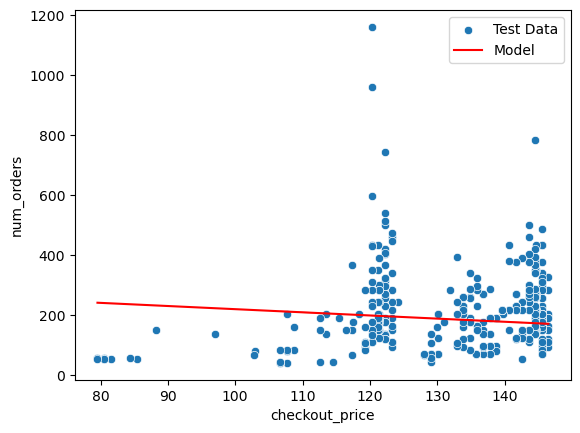

In [84]:
# Test
sns.scatterplot(x="checkout_price", y="num_orders", data=test_data, label="Test Data")
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data, color="red", label="Model"
)

In [85]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error_train = mean_squared_error(
    train_data["num_orders"], train_data["predictions"]
)
print(f"Train MSE: {mean_squared_error_train:.2f}")
mean_squared_error_test = mean_squared_error(
    test_data["num_orders"], test_data["predictions"]
)
print(f"Test MSE: {mean_squared_error_test:.2f}")

Train MSE: 3621.02
Test MSE: 20190.87


<table>
  <thead>
    <tr>
      <th>Причина</th>
      <th>Ознака</th>
      <th>Рішення</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>Overfitting</b></td>
      <td>Test MSE ≫ Train MSE</td>
      <td>Спрощення моделі, регуляризація</td>
    </tr>
    <tr>
      <td><b>Розбіжність у Train/Test</b></td>
      <td>Test ≠ Train розподіл</td>
      <td>Рандомізація, перевірка розподілів</td>
    </tr>
    <tr>
      <td><b>Мало тренувальних даних</b></td>
      <td>Висока похибка на тесті</td>
      <td>Збір або генерація нових даних</td>
    </tr>
    <tr>
      <td><b>Шум або погані фічі</b></td>
      <td>Модель "вгадує"</td>
      <td>Відбір ознак (feature selection)</td>
    </tr>
    <tr>
      <td><b>Погане масштабування</b></td>
      <td>Високий MSE</td>
      <td>Стандартизація/нормалізація</td>
    </tr>
  </tbody>
</table>


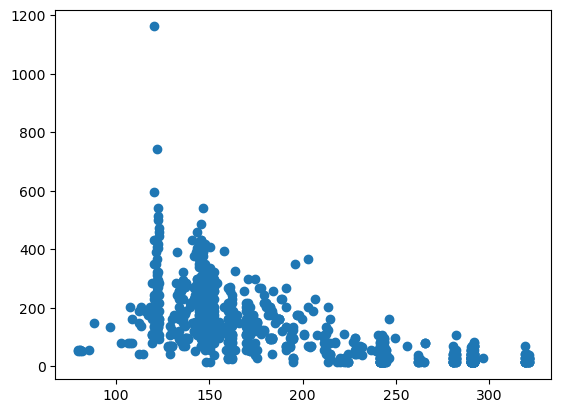

In [86]:
# Shaffle
train_data, test_data = train_test_split(
    df_slice, shuffle=True, test_size=0.25,
)
plt.scatter(
    train_data["checkout_price"], train_data["num_orders"], label="Train Data"
)

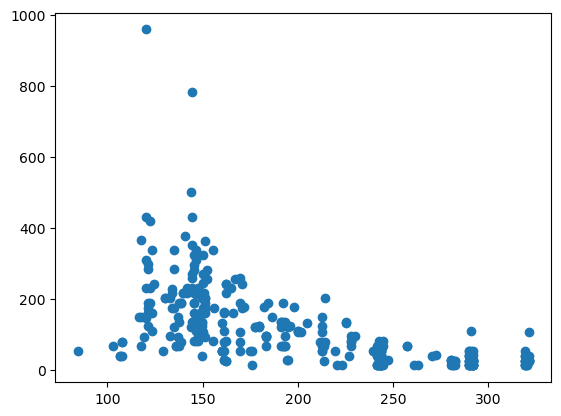

In [87]:
plt.scatter(
    test_data["checkout_price"], test_data["num_orders"], label="Test Data"
)

In [88]:
x = train_data["checkout_price"].to_numpy().reshape(-1, 1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x, y)
train_data["predictions"] = model.predict(x)

x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
test_data["predictions"] = model.predict(x_test)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

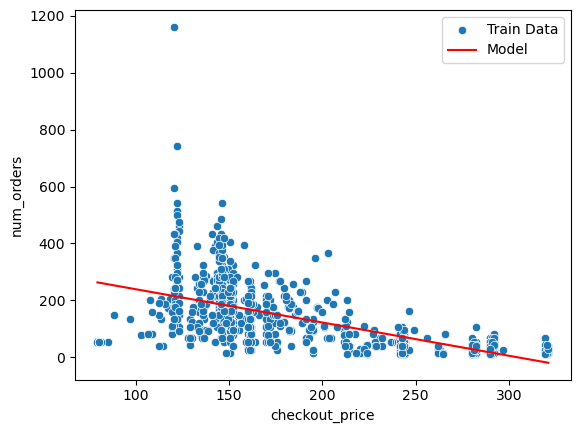

In [89]:
sns.scatterplot(
    x="checkout_price", y="num_orders", data=train_data, label="Train Data"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=train_data, color="red", label="Model"
)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

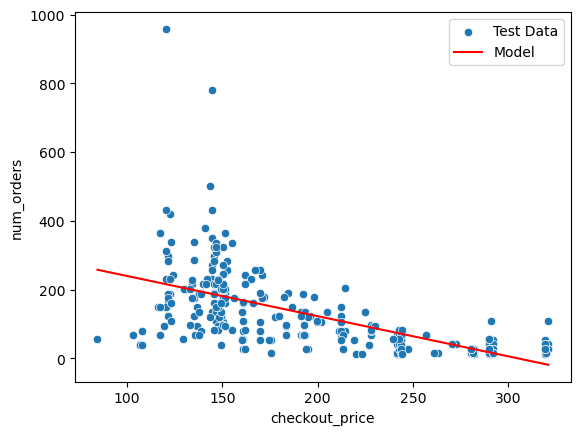

In [90]:
sns.scatterplot(
    x="checkout_price", y="num_orders", data=test_data, label="Test Data"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data, color="red", label="Model"
)

In [91]:
mean_squared_error_train = mean_squared_error(
    train_data["num_orders"], train_data["predictions"]
)
print(f"Train MSE: {mean_squared_error_train:.2f}")
mean_squared_error_test = mean_squared_error(
    test_data["num_orders"], test_data["predictions"]
)
print(f"Test MSE: {mean_squared_error_test:.2f}")

Train MSE: 7478.46
Test MSE: 8253.62


<h3>📈 Висновки по якості моделі</h3>

<ul>
  <li><b>Train MSE:</b> 7478.46</li>
  <li><b>Test MSE:</b> 8253.62</li>
</ul>

<p>✅ <b>Результати свідчать про хорошу узагальнюваність моделі:</b></p>

<ul>
  <li>Помилки на тренувальних і тестових даних подібні — <b>немає overfitting</b></li>
  <li>Модель не просто запам'ятала дані, а <b>навчилася робити передбачення</b> на нових прикладах</li>
  <li>Різниця між Train і Test MSE становить менше ніж 10% — <b>це дуже добре</b></li>
</ul>

<h4>🛠️ Рекомендації:</h4>
<ul>
  <li>Можна додатково проаналізувати важливість ознак (feature importance)</li>
  <li>Перевірити залишки (residuals), щоб знайти, де модель найбільше помиляється</li>
  <li>Розглянути інші метрики: MAE, R², MAPE тощо</li>
  <li>Можна спробувати легкий тюнінг гіперпараметрів або ансамблювання</li>
</ul>


## Cross Validation

https://scikit-learn.org/stable/modules/cross_validation.html

<p align="center">
  <img src="./data/grid_search_cross_validation.png" alt="Cross Validation" width="500"/>
</p>

In [92]:
from sklearn import model_selection

X = range(10)
X

range(0, 10)

In [93]:
kf = model_selection.KFold(n_splits=5)
for train_indices, test_indices in kf.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    

TRAIN: [2 3 4 5 6 7 8 9] TEST: [0 1]
TRAIN: [0 1 4 5 6 7 8 9] TEST: [2 3]
TRAIN: [0 1 2 3 6 7 8 9] TEST: [4 5]
TRAIN: [0 1 2 3 4 5 8 9] TEST: [6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8 9]


In [94]:
kf = model_selection.KFold(n_splits=2, shuffle=True)
for train_indices, test_indices in kf.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)

TRAIN: [0 1 3 5 8] TEST: [2 4 6 7 9]
TRAIN: [2 4 6 7 9] TEST: [0 1 3 5 8]


In [95]:
kf = model_selection.KFold(n_splits=2, shuffle=True, random_state=1)
for train_indices, test_indices in kf.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    print("TRAIN labels:", y[train_indices])
    print("TEST labels:", y[test_indices])

TRAIN: [1 3 5 7 8] TEST: [0 2 4 6 9]
TRAIN labels: [ 96  80 121  80 460]
TEST labels: [ 27  14  15 162 176]
TRAIN: [0 2 4 6 9] TEST: [1 3 5 7 8]
TRAIN labels: [ 27  14  15 162 176]
TEST labels: [ 96  80 121  80 460]


In [96]:
X = range(12)

In [97]:
y = np.array([0] * 6 + [1] * 6)  # 0 for first 6, 1 for next 6
print(y)

skf = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
for train_indices, test_indices in skf.split(X, y):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    print("TRAIN labels:", y[train_indices])
    print("TEST labels:", y[test_indices])

[0 0 0 0 0 0 1 1 1 1 1 1]
TRAIN: [ 0  3  5  7  8 11] TEST: [ 1  2  4  6  9 10]
TRAIN labels: [0 0 0 1 1 1]
TEST labels: [0 0 0 1 1 1]
TRAIN: [ 1  2  4  6  9 10] TEST: [ 0  3  5  7  8 11]
TRAIN labels: [0 0 0 1 1 1]
TEST labels: [0 0 0 1 1 1]


In [98]:
y = np.array([0, 1] * 6)  # 0 for first 6, 1 for next 6
print(y)

skf = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
for train_indices, test_indices in skf.split(X, y):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    print("TRAIN labels:", y[train_indices])
    print("TEST labels:", y[test_indices])
# StratifiedKFold ensures that each fold has the same proportion of classes as the entire dataset.
# This is particularly useful for imbalanced datasets, where one class may be underrepresented.

[0 1 0 1 0 1 0 1 0 1 0 1]
TRAIN: [ 0  3  5  6 10 11] TEST: [1 2 4 7 8 9]
TRAIN labels: [0 1 1 0 0 1]
TEST labels: [1 0 0 1 0 1]
TRAIN: [1 2 4 7 8 9] TEST: [ 0  3  5  6 10 11]
TRAIN labels: [1 0 0 1 0 1]
TEST labels: [0 1 1 0 0 1]


In [99]:
ss = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)

for train_indices, test_indices in ss.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)
# ShuffleSplit randomly splits the data into training and testing sets multiple times, without preserving the class distribution.

TRAIN: [ 6  5  8 11  4  1  0  7 10] TEST: [3 9 2]
TRAIN: [ 3 11  6  2  8  9  4  5 10] TEST: [0 1 7]
TRAIN: [ 6  7  5 10  1  9  8  0  3] TEST: [ 2  4 11]
TRAIN: [ 6 11 10  0  4  5  9  3  2] TEST: [7 8 1]
TRAIN: [ 5  7  6 10  0 11  4  1  8] TEST: [2 3 9]
TRAIN: [ 4  7  8  5  6 10  3  0  9] TEST: [ 2 11  1]
TRAIN: [ 9  0 10  3  1  2 11  5  8] TEST: [4 6 7]
TRAIN: [ 4  0  9  1 11  7  2  6  8] TEST: [ 3  5 10]
TRAIN: [ 8  4  9  0  1  2 11  3 10] TEST: [5 7 6]
TRAIN: [ 9  4 10  8  7  1 11  2  3] TEST: [0 6 5]


In [100]:
X = range(10)
target = np.array([0] * 5 + [1] * 5)  # 0 for first 5, 1 for next 5 
print(target)

sss = model_selection.StratifiedShuffleSplit(n_splits=4, test_size=0.2)
for train_indices, test_indices in sss.split(X, target):
    print("TRAIN:", train_indices, "TEST:", test_indices)

[0 0 0 0 0 1 1 1 1 1]
TRAIN: [2 5 4 1 6 7 9 3] TEST: [8 0]
TRAIN: [4 6 8 7 5 2 0 3] TEST: [9 1]
TRAIN: [7 8 4 6 0 1 3 9] TEST: [2 5]
TRAIN: [9 4 0 2 6 7 8 1] TEST: [5 3]


In [101]:
loo = model_selection.LeaveOneOut()

for train_indices, test_indices in loo.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)

TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]


## Regularization
Ridge Regression: in ridge regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients.

Classic linear regression:

$$
\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p
$$
**Where:**
$$
- \( \hat{y} \): predicted value (output)
- \( \beta_0 \): intercept (bias term)
- \( \beta_1, \beta_2, \dots, \beta_p \): model coefficients (weights)
- \( x_1, x_2, \dots, x_p \): input features (predictors)
$$
---

Sum of squares in classic linear regression:

**TSS (Total Sum of Squares):** total variation in the observed data  
  $$
  TSS = \sum_{i=1}^{n} (y_i - \bar{y})^2
  $$

- **SSR (Sum of Squares due to Regression):** variation explained by the model  
  $$
  SSR = \sum_{i=1}^{n} (\hat{y}_i - \bar{y})^2
  $$

- **SSE (Sum of Squared Errors / Residuals):** variation not explained by the model  
  $$
  SSE = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  $$

**Relationship:**

$$
TSS = SSR + SSE
$$
$$

